# Реализация игры he Knight and the Princess с помощью Q-learning

--------------------------------------------------
### Марк Бодров (Б03-909б)
[оригинальная статья - Diving deeper into Reinforcement Learning with Q-Learning](https://www.freecodecamp.org/news/diving-deeper-into-reinforcement-learning-with-q-learning-c18d0db58efe/)

--------------------------------------------------

## Правила игры

<div>
<img src="https://raw.githubusercontent.com/mrpepperbest/Control_Theory/main/RL/img1.png" width="300"/>  
</div>

<font size="3">  Агент начинает игру в произвольном свободном положении (на примере в верхнем левом углу поля) и заканчивает в ячейке с <span style='color:green'>+100 ("Замок принцессы")</span>  либо в одной из ячеек с <span style='color:red'>-100 ("Стражник")</span>. 
    На каждом шагу он может двигаться вертикально или горизонтально, на одну ячейку, но на каждом шаге теряет 1 очко (<span style='color:orange'>получает -1</span>), поэтому ему нужно добраться самым быстрым путем из возможных.</font>

</font> <font size="3">Подразумевается, что действие на каждом шаге детерминировано, то есть если агент выбрал действие "переместиться в клетку справа", то именно такое действие и реализуется (нет случайных факторов, которые могут повлиять на выполнение команды).</font>

--------------------------------------------------

## Поле
<font size="3">Задаются переменные, определяющие поле для игры.</font>

In [38]:
# Импортируем библиотеки
import numpy as np 
import random

# Параметры поля
BOARD_ROWS = 5 # размеры поля
BOARD_COLS = 5
WIN_STATE = (4, 2) # положение Замка
ENEMIES = [(1,1), (1,3), (3,1), (3,3)] # позиции "Стражников"
START = (0, 0) # поле "Старт"

## Алгортим обучения агента
 
<font size="3"> Для обучения агента будет задействована функцию качества (Q-функция):\
    \
$$
    \begin{equation}
    Q(s,a) = \sum_{s'} T(s,a,s')(R(s,a,s') + \gamma V(s'))
    \end{equation}
$$  
Функция полезности (V-функция):    
$$
    \begin{equation}
            V(s) = E \left (\sum_{t=0}^{\infty} \gamma^t r_t | \pi(s),\, s_0 = s \right) 
    \end{equation}
$$   
    Для каждого состояния (s) будет рассмотрен кортеж $(s, a, r, s')$:
    и рассчитано значение функции качества по принципу оптимальности Беллмана:
$$
\begin{equation}\label{eq:bellmanQ}
Q(s,a) = \sum_{s'} T(s,a,s')(R(s,a,s') + \gamma \max_{a'} Q(s',a'))
\end{equation}
$$
<font size="3"> Для удобства рассчета задействуется таблица качества (Q-таблица), содержащая все возможные состояния (строки) и все возможные действия (столбцы) для каждого из них (в данном случае для каждого состояния 4 действия):<br>
<br>
    </font>    
    
</font>
<div>
<img src="https://raw.githubusercontent.com/mrpepperbest/Control_Theory/main/RL/img2.png" width="300"/>  
</div>
<font size="3"> <br>На иллюстрации представлена сетка, более наглядная в данном случае. Нулями заполнены недопустимые действия.</font>
<font size="3"> <br>Для заполнения таблицы будет задействован следующий алгоритм:<br> 
    1. Заполнение таблицы произвольными значениями Q(s,a).<br>
    2. До конца обучения: <br>
            &nbsp;&nbsp;&nbsp;&nbsp;2.1. Выбор действия(a) в нынешнем состоянии(s) на основании нынешних рассчетов Q(s,...).<br>
            &nbsp;&nbsp;&nbsp;&nbsp;2.2. Совершение действия(a) и исследование полученных в результате состояния(s') и вознаграждения(r).<br>
            &nbsp;&nbsp;&nbsp;&nbsp;2.3. Обновление значений функции качества в таблице.<br>
</font>


<font size="3">Обновление значения функции качества в таблице происходит следующим образом:<br><br>
</font>
<font size="3">&nbsp;&nbsp;&nbsp;&nbsp;1. Вычисляется промежуточное значение функции качества:</font>
### &nbsp;&nbsp;&nbsp;&nbsp; $\hat{Q}(s, a) = R(s,a,s') + \gamma \cdot \max_{a}{Q_k(s',a')}$
<br>
<font size="3">&nbsp;&nbsp;&nbsp;&nbsp;2. Вычисляется новая оценка для Q-функции как взвешенная сумма имеющейся оценки и новой информации   $\hat{Q}(s,a)$:</font>

### &nbsp;&nbsp;&nbsp;&nbsp;$Q_{k+1}(s, a) = (1-\alpha) \cdot Q_{k}(s, a) + \alpha \cdot \hat{Q}(s,a) =  Q_{k}(s, a) + \alpha \cdot (\hat{Q}(s,a) - Q_{k}(s, a))$

<font size="3">&nbsp;&nbsp;&nbsp;&nbsp; Таблица сначала будет инициализирована нулями. Ввиду того, что выбор действий будет затруднен, когда все значения нулевые, будет введен коэффициент $\varepsilon$ - коэффициент исследования (exploration rate). Это доля шагов, которые будут совершаться агентом случайно. Сначала $\varepsilon$ будет равен 1 (максимальное значение), т.к. сначала ничего неизвестно о значениях Q-таблицы и исследование очень важно, далее он будет уменьшаться.<br>
Если случайно сгенерированное число [0,1] будет больше $\varepsilon$, то агент сможет "сжульничать" и определить следующее действие табличным значением, если меньше, то действие будет определено случайно.
</font>

## Создание Q-таблицы

In [39]:
actions = ["up", "down", "left", "right"] # из 1 состояния можно совершить 4 действия
# Q-таблица это словарь из словарей с нулями, с размерами {BOARD_COLS, BOARD_ROWS, action_size}.
qtable = {}
for i in range(BOARD_ROWS): 
    for j in range(BOARD_COLS):
        qtable[(i, j)] = {}
        for a in actions:
            qtable[(i, j)][a] = -0  

## Параметры обучения

In [40]:
total_episodes = 15000        # Общее количество симуляций (эпизодов)
learning_rate = 0.8           # Темп обучения (learning rate)
max_steps = 99                # Максимальное количество шагов в одной симуляции(эпизоде)
gamma = 0.95                  # Коэффициент дисконтирования награды

# Параметры исследования
epsilon = 1.0                 # Коэффициент исследования
max_epsilon = 1.0             # Начальная вероятность случайного действия (исследования)
min_epsilon = 0.01            # Минимальная вероятность случайного действия (исследования)
decay_rate = 0.005            # Экспоненциальный коэффициент уменьшения для вероятности исследования

## Модель игры
<font size="3"> Создаются функции и классы, реализующие игровые механики.</font>

<font size="3">Класс State определяет параметры текущего состояния, а также возвращает следущее состояние в зависимости от выбранного действия.</font>

<font size="3">Класс Agent определяет следующее действие, совершает действие, обновляет симуляцию и обучается.</font>

In [41]:
class State:
    def __init__(self, state=START):
        self.board = np.zeros([BOARD_ROWS, BOARD_COLS])
        self.board[WIN_STATE] = 100
        for i in ENEMIES:
            self.board[tuple(i)] = -100
        self.state = state
        self.isEnd = False

        
    def giveReward(self):
        """
        Определяет награду, согласно текущему состоянию
        :return: Награда ячейки
        """
        if self.state == WIN_STATE:
            return 100
        else:
            for i in ENEMIES:
                if self.state == i:
                    return -100
        return -1
    
    
    def isEndFunc(self):
        """
        Определяет, является ли текущее состояние state терминальным
        """
        for i in ENEMIES:
            if (self.state == i) or (self.state == WIN_STATE):
                self.isEnd = True
                
        
    def nextPosition(self, action):
        """
        Переход в следующее состояние после выбора действия (action)
        :param action: Флаг состояния, в которое необходимо перейти, одно из: up, down, left, right
        :return: Следующая позиция на доске
        """
        # Определение нового поля
        if action == "up":
            nextState = (self.state[0] - 1, self.state[1])
        elif action == "down":
            nextState = (self.state[0] + 1, self.state[1])
        elif action == "left":
            nextState = (self.state[0], self.state[1] - 1)
        else:
            nextState = (self.state[0], self.state[1] + 1)

        # Проверка на нахождение в границах
        if (nextState[0] >= 0) and (nextState[0] < BOARD_ROWS):
            if (nextState[1] >= 0) and (nextState[1] < BOARD_COLS):
                    return nextState
                
        return self.state
        

    def showBoard(self):
        """
        Вывод игрового поля
        """
        self.board[self.state] = 1
        for i in range(0, BOARD_ROWS):
            stick = '----'*BOARD_COLS+'-' 
            print(stick)
            out = '| '
            for j in range(0, BOARD_COLS):
                if self.board[i, j] == 1:
                    token = '*'
                if self.board[i, j] == -100:
                    token = 'g'
                if self.board[i, j] == 0:
                    token = '0'
                if self.board[i, j] == 100:
                    token = '⚐'
                out += token + ' | '
            print(out)
        print(stick)

In [42]:
class Agent:

    def __init__(self):
        self.states = []        # инициализация 
        self.actions = actions  # действия агента
        self.State = State()  # инициализация состояния
        self.isEnd = self.State.isEnd # инициализация флага окончания симуляции
        self.lr = learning_rate  # learning rate - скорость обучения \alpha
        self.exp_rate = epsilon     # exploration rate - вероятность исследования
        self.gamma = gamma   # показатель степени для вычисления кумулятивного вознаграждения
        self.decay_rate = decay_rate  # экспоненциальный коэффициент уменьшения для вероятности исследования
        self.Q_values = qtable # начальная таблица

    
    def reduceEpsilon(self, episode):
        """
        Изменение вероятности исследования
        :param episode: Номер эпизода (симуляции)
        """
        self.exp_rate = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-self.decay_rate*episode)
        
    def possible_actions(self, actions):
        """
        Определение допустимых действий данного состояния
        :param actions: Список всех действий
        :return: Список допустимых действий
        """
        actions_ = list(actions)
        if (self.State.state[0] == 0): actions_.remove('up')
        if (self.State.state[0] == BOARD_ROWS-1): actions_.remove('down')
        if (self.State.state[1] == 0): actions_.remove('left')
        if (self.State.state[1] == BOARD_COLS-1): actions_.remove('right')
        return actions_

    def chooseAction(self):
        """
        Выбор действия в текущем состоянии
        :return: Флаг действия, одно из: up, down, left, right
        """
        max_next_reward = -100
        action = ""
        actions = self.possible_actions(self.actions)

        if np.random.uniform(0, 1) <= self.exp_rate: # Возможность случайного действия
            action = np.random.choice(actions)
        else:
            # жадный выбор
            for i in actions:
                current_position = self.State.state
                next_reward = self.Q_values[current_position][i]
                if next_reward >= max_next_reward:
                    action = i
                    max_next_reward = next_reward
        return action
    
    def chooseDefAction(self):
        """
        Выбор детерменированного действия в текущем состоянии, на основании таблицы Q
        :return: Флаг действия, одно из: up, down, left, right
        """
        current_position = self.State.state
        action = max(self.Q_values[current_position], key = self.Q_values[current_position].get)
        return action

    
    def takeAction(self, action):
        """
        Выполнить действие и перейти в следующее состояние
        :param action: действие, которое необходимо выполнить
        :return: Обновленное состояние
        """
        position = self.State.nextPosition(action)
        return State(state=position)

    
    def reset(self):
        """
        Выполнить сброс истории
        """
        self.states = []
        self.State = State()
        self.isEnd = self.State.isEnd


## Реализация алгоритма обучения

Функция, осуществляющая запуск циклического алгоритма обучения агента, описанного ранее. Совершает все шаги на протяжении установленного числа эпизодов. Для наглядности также будут созданы массивы коэффициентов обучения и суммарных наград за эпизод.

In [43]:
def learn(agent, rounds):
    """
    Запуск цикла из N симуляций для обучения агента
    :param agent: Сущность агента, которая будет обучаться
    :param rounds: Количество эпизодов в симуляции (N)
    :return: Списки всех наград и всех learning_rate за эпизоды
    """
    epsilons, all_rewards = [], []
    total_rewards = 0 # Инициализация суммарного вознаграждения за игру
    for i in range(rounds):
        # Запуск цикла по всем эпизодам
        if agent.State.isEnd: # Проверка конца игры
            # Итоговый вывод
            print("Game End Reward", total_rewards) # Отчет об эпизоде
            print("---------------------")
            # Перезапуск эпизода
            agent.reset()
            # Обнуление суммарного вознаграждения для запуска нового эпизода
            all_rewards.append(total_rewards)
            total_rewards = 0
        else:
            action = agent.chooseAction() # Выбор действия агентом (a)
            agent.states.append([(agent.State.state), action]) # Отслеживание пути перемещения агента
            print("current position {} action {}".format(agent.State.state, action)) # Вывод отчета
            
            state = agent.State.state # запись текущего состояния (s)
            agent.State = agent.takeAction(action) # совершение выбранного действия (a)          
            new_state, reward = agent.State.state, agent.State.giveReward() # изучение нового состояния (s') и награды (r)
            # Вычисление Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
            max_Q = agent.Q_values[new_state][max(agent.Q_values[new_state], key = agent.Q_values[new_state].get)]
            Q_value = agent.Q_values[state][action] + agent.lr * ((reward + agent.gamma * max_Q) - agent.Q_values[state][action])
            agent.Q_values[state][action] = round(Q_value, 3)  # Обновление таблицы        
            total_rewards += reward # Запись суммарной награды
            # Отчет о шаге эпизода
            agent.State.isEndFunc()
            print("isEnd", agent.State.isEndFunc())
            print("epsilon", round(agent.exp_rate, 3))
            print("next state", agent.State.state)
            print("---------------------")
            agent.isEnd = agent.State.isEnd
        # Уменьшение exploration rate - вероятности исследования
        agent.reduceEpsilon(i)
        epsilons.append(round(agent.exp_rate, 3))
            
    return epsilons, all_rewards
            

 ## Запуск обучения
 Запуск функции с заданными параметрами. Ниже приведен график зависимости темпа исследования (exploration rate) в зависимости от номера эпизода

In [44]:
agent = Agent()
print("initial Q-values ... \n")
print(agent.Q_values)
a = learn(agent, total_episodes)

initial Q-values ... 

{(0, 0): {'up': 0, 'down': 0, 'left': 0, 'right': 0}, (0, 1): {'up': 0, 'down': 0, 'left': 0, 'right': 0}, (0, 2): {'up': 0, 'down': 0, 'left': 0, 'right': 0}, (0, 3): {'up': 0, 'down': 0, 'left': 0, 'right': 0}, (0, 4): {'up': 0, 'down': 0, 'left': 0, 'right': 0}, (1, 0): {'up': 0, 'down': 0, 'left': 0, 'right': 0}, (1, 1): {'up': 0, 'down': 0, 'left': 0, 'right': 0}, (1, 2): {'up': 0, 'down': 0, 'left': 0, 'right': 0}, (1, 3): {'up': 0, 'down': 0, 'left': 0, 'right': 0}, (1, 4): {'up': 0, 'down': 0, 'left': 0, 'right': 0}, (2, 0): {'up': 0, 'down': 0, 'left': 0, 'right': 0}, (2, 1): {'up': 0, 'down': 0, 'left': 0, 'right': 0}, (2, 2): {'up': 0, 'down': 0, 'left': 0, 'right': 0}, (2, 3): {'up': 0, 'down': 0, 'left': 0, 'right': 0}, (2, 4): {'up': 0, 'down': 0, 'left': 0, 'right': 0}, (3, 0): {'up': 0, 'down': 0, 'left': 0, 'right': 0}, (3, 1): {'up': 0, 'down': 0, 'left': 0, 'right': 0}, (3, 2): {'up': 0, 'down': 0, 'left': 0, 'right': 0}, (3, 3): {'up': 0, 'dow

Text(0, 0.5, 'exploration rate')

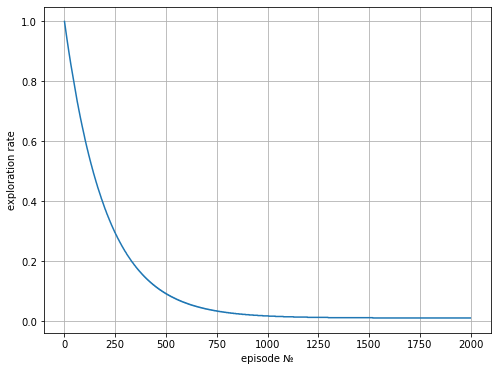

In [45]:
import matplotlib.pyplot as plt
import numpy as np

t = np.arange(0, total_episodes)
plt.figure(figsize  = (8,6))
plt.plot(t[0:2000], a[0][0:2000])
plt.grid()
plt.xlabel('episode №')
plt.ylabel('exploration rate')


 ## Проверка обученного агента
 Запуск эпизода, где агент совершает все действия на основании обучения (ранее составленной таблицы Q). Ниже приведена необходимая для этого функция.
 В конце документа продемонстрирован вариант подобного прохождения (агент обучался 15000 эпизодов).

In [46]:
def walkthrough(agent):
    """
    Прохождение игры на основании обучения
    :param agent: Сущность агента
    """
    agent.reset()
    total_rewards = 0 # Инициализация суммарного вознаграждения за игру
    while not agent.State.isEnd:
        action = agent.chooseDefAction() # Выбор действия агентом (a)
        agent.states.append([(agent.State.state), action]) # Отслеживание пути перемещения агента
        print("current position {} action {}".format(agent.State.state, action)) # Вывод отчета
        agent.State = agent.takeAction(action) # совершение выбранного действия (a)          
        reward = agent.State.giveReward() # запись вознаградения (r)  
        total_rewards += reward # Запись суммарной награды
        # Отчет о шаге эпизода
        agent.State.isEndFunc()
        print("isEnd", agent.State.isEndFunc())
        print("epsilon", round(agent.exp_rate, 3))
        print("next state", agent.State.state)
        print("---------------------")
        print("Game state:")
        agent.State.showBoard()
        agent.isEnd = agent.State.isEnd
    # Проверка конца игры
    # Итоговый вывод
    print("---------------------")
    print("Агент завершил игру за",len(agent.states)-1, "шагов")
    print("С общим счетом:", total_rewards) # Отчет об эпизоде
            

In [47]:
walkthrough(agent)

current position (0, 0) action down
isEnd None
epsilon 0.01
next state (1, 0)
---------------------
Game state:
---------------------
| 0 | 0 | 0 | 0 | 0 | 
---------------------
| * | g | 0 | g | 0 | 
---------------------
| 0 | 0 | 0 | 0 | 0 | 
---------------------
| 0 | g | 0 | g | 0 | 
---------------------
| 0 | 0 | ⚐ | 0 | 0 | 
---------------------
current position (1, 0) action down
isEnd None
epsilon 0.01
next state (2, 0)
---------------------
Game state:
---------------------
| 0 | 0 | 0 | 0 | 0 | 
---------------------
| 0 | g | 0 | g | 0 | 
---------------------
| * | 0 | 0 | 0 | 0 | 
---------------------
| 0 | g | 0 | g | 0 | 
---------------------
| 0 | 0 | ⚐ | 0 | 0 | 
---------------------
current position (2, 0) action down
isEnd None
epsilon 0.01
next state (3, 0)
---------------------
Game state:
---------------------
| 0 | 0 | 0 | 0 | 0 | 
---------------------
| 0 | g | 0 | g | 0 | 
---------------------
| 0 | 0 | 0 | 0 | 0 | 
---------------------
| * | g | 0 |